# `Example`: Data-Driven Minimum-Variance Portfolio Allocation for Risky Assets
[Markowitz portfolio allocation](https://en.wikipedia.org/wiki/Markowitz_model) identifies the weights $\omega$'s for assets in a portfolio such that the portfolio variance (risk) is minimized for a specified rate of portfolio return (reward). The Markowitz allocation problem for a portfolio $\mathcal{P}$ composed of only risky assets is given by:

\begin{eqnarray*}
\text{minimize}~\sigma_{\mathcal{P}}^2 &=& \sum_{i\in\mathcal{P}}\sum_{j\in\mathcal{P}}\omega_{i}\omega_{j}
\text{cov}\left(r_{i},r_{j}\right) \\
\text{subject to}~\mathbb{E}(r_{\mathcal{P}})& = & \sum_{i\in\mathcal{P}}\omega_{i}\cdot\mathbb{E}(r_{i})\geq{R^{*}}\\
\sum_{i\in\mathcal{P}}\omega_{i} & = & 1\\
\text{and}~\omega_{i}&\geq&{0}\qquad{\forall{i}\in\mathcal{P}}
\end{eqnarray*}

The term $\omega_{i}\geq{0}$ denotes the dollar fraction of asset $i$ in the portfolio $\mathcal{P}$, $R^{*}$ is the minimal required return for $\mathcal{P}$, $\sigma_{\mathcal{P}}$ denotes the portfolio variance, $r_{i}$ denotes the return for asset $i$ and $\text{cov}\left(r_{i},r_{j}\right)$ denotes the [covariance](https://en.wikipedia.org/wiki/Covariance) between the return of asset $i$ and $j$ in the portfolio. In a `data-driven` approach, we estimate the expected returns and the covariance directly from the data, as opposed to using a model of some sort. 

### Learning objectives
In this example, we'll compute the [Efficient Frontier](https://en.wikipedia.org/wiki/Efficient_frontier) for a portfolio of risky assets, where the expected return and the covariance of the returns are calculated from a historical dataset. 

* __Prerequisites__: we'll begin by loading the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `12-01-2023`.
* __Task 1__: Next, we'll compute the analyzed expected returns and the covariance arrays from this historical dataset and analyze these values
* __Task 2__: Finally, we'll compute the efficient frontier by solving the optimization problem described above: minimize the risk for a specified minimum reward value, visualize the efficient frontier, and look at some sample portfolios that lie on the efficient frontier.

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

### Types
The `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, which encodes data required to compute the efficient frontier for a collection of $N$ risky assets only, has the fields:
* `Σ::Array{Float64,2}` is the $N\times{N}$ covariance matrix, with entries $cov(r_{i},r_{j})$
* `μ::Array{Float64,1}` is the $N\times{1}$ vector of expected return values with elements $\mathbb{E}(r_{i})$
* `bounds::Array{Float64,2}` is an $N\times{2}$ array that holds the upper and lower bound for the asset allocation. Each row corresponds to an asset, while the first column is the lower bound, and the second column is the upper bound on the asset allocation fraction.
* `R::Float64` denotes the lower bound on the desired return
* `initial::Array{Float64,1}` is the $N\times{1}$ array of initial guesses

The `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem`, which encodes data required to compute the optimal allocation for a portfolio containing $N$ risky assets and a single risk-free asset, has the fields:
* `Σ::Array{Float64,2}` is the $N\times{N}$ covariance matrix, with entries $cov(r_{i},r_{j})$
* `μ::Array{Float64,1}` is the $N\times{1}$ vector of expected return values, with elements $\mathbb{E}(r_{i})$
* `bounds::Array{Float64,2}` is an $N\times{2}$ array that holds the upper and lower bound for the asset allocation. Each row corresponds to an asset, while the first column is the lower bound, and the second column is the upper bound on the asset allocation fraction.
* `R::Float64` denotes the lower bound on the desired return
* `initial::Array{Float64,1}` is the $N\times{1}$ array of initial guesses
* `risk_free_rate::Float64` is the risk-free rate of return, e.g., the rate of return on a [10-year US Treasury Note](https://www.cnbc.com/bonds/)

### Functions
* The `MyMarketDataSet()` function loads the risky asset price dataset and returns it as a [DataFrame.jl](https://dataframes.juliadata.org/stable/) instance. 
* The `build(...)` is a factory method that takes the type of object that you wish to construct and the parameters required to construct the object, e.g., the fields of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` or `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` types.
* The `solve(...)` method takes a `problem` type, e.g., an instance of `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` and returns the solution to the problem as a [Julia Dictionary](https://docs.julialang.org/en/v1/base/collections/#Dictionaries) instance.

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `10-31-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyMarketDataSet()` function:

In [7]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of tradition days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [9]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [11]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset

Dict{String, DataFrame} with 460 entries:
  "NI"   => 1508×8 DataFrame…
  "EMR"  => 1508×8 DataFrame…
  "CTAS" => 1508×8 DataFrame…
  "HSIC" => 1508×8 DataFrame…
  "KIM"  => 1508×8 DataFrame…
  "PLD"  => 1508×8 DataFrame…
  "IEX"  => 1508×8 DataFrame…
  "BAC"  => 1508×8 DataFrame…
  "CBOE" => 1508×8 DataFrame…
  "EXR"  => 1508×8 DataFrame…
  "NCLH" => 1508×8 DataFrame…
  "CVS"  => 1508×8 DataFrame…
  "DRI"  => 1508×8 DataFrame…
  "DTE"  => 1508×8 DataFrame…
  "ZION" => 1508×8 DataFrame…
  "AVY"  => 1508×8 DataFrame…
  "EW"   => 1508×8 DataFrame…
  "EA"   => 1508×8 DataFrame…
  "NWSA" => 1508×8 DataFrame…
  "CAG"  => 1508×8 DataFrame…
  "GPC"  => 1508×8 DataFrame…
  "FCX"  => 1508×8 DataFrame…
  "GILD" => 1508×8 DataFrame…
  "UNP"  => 1508×8 DataFrame…
  "CDW"  => 1508×8 DataFrame…
  ⋮      => ⋮

Lastly, let's get a list of firms that we have in cleaned up `dataset`, and save it ib the `all_tickers` array

In [13]:
all_tickers = keys(dataset) |> collect |> sort;

### Compute the covariance and expected growth for all firms in the dataset
The expected growth $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll need to compute values for both of these quantities for the entire data set (all `N = 459` tickers), and then we'll filter out which tickers we are interested in. 

* First, we compute the expected (annualized) log growth rate by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [15]:
all_firms_return_matrix = log_growth_matrix(dataset, all_tickers, Δt = (1/252.0));

* Next, we estimate the expected return for each firm from the `all_firms_return_matrix` using the [mean(...) function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean), which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We set the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(r_{1}),\dotsc,\mathbb{E}(r_{N})$ to the array $\mu$:

In [17]:
μ = mean(all_firms_return_matrix, dims=1) |> vec;

* Finally, we estimate the annualized `covariance_matrix` (assuming `252` trading days per year) from the `all_firms_return_matrix` using the [cov(...) function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cov), exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ covariance matrix in the $\Sigma$ variable:

In [19]:
Σ = cov(all_firms_return_matrix) |> x-> x*(1/252) # annualized, historical volatility

460×460 Matrix{Float64}:
 0.0655367  0.0409146  0.0273076  …  0.0444449  0.0343089  0.0362875
 0.0409146  0.283809   0.0573645     0.069817   0.0986843  0.0383996
 0.0273076  0.0573645  0.12501       0.0392735  0.0510524  0.0292667
 0.0323065  0.0444841  0.0236737     0.045334   0.0268079  0.0336129
 0.0198861  0.0206277  0.0201981     0.0175898  0.0216887  0.0225977
 0.0317812  0.0228434  0.0180639  …  0.0300955  0.0202344  0.0301296
 0.0345523  0.0475915  0.0321036     0.0448403  0.0392157  0.0353211
 0.0387532  0.0358116  0.0245768     0.0519358  0.023438   0.0383791
 0.0383595  0.063833   0.0295398     0.055052   0.0425233  0.033446
 0.0209082  0.047045   0.0262508     0.0282589  0.0450202  0.0181709
 0.028523   0.0471555  0.0297807  …  0.0372987  0.0362684  0.030892
 0.0483308  0.0647852  0.0352406     0.0650439  0.041227   0.0429126
 0.0167745  0.0184331  0.0190468     0.0163051  0.0187535  0.0207827
 ⋮                                ⋱                        
 0.0225894  0.054666

## Task 1: Build the log return array and covariance matrix for a sample portfolio
Before we compute the efficient frontier, we must decide which tickers to include in the risky portfolio. For now, let's select a few tickers at random.
* Specify a collection of `ticker symbols`, e.g., `AAPL`, `MSFT`, etc., that interest you in the `my_list_of_tickers` array. We'll put the indexes of your tickers in the `my_list_of_firm_ids` array:

In [21]:
my_list_of_tickers = ["AAPL", "MSFT", "INTC", "MU", "AMD", "GS", "BAC", "WFC", "C", "F", "GM"];
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_list_of_tickers
    firm_index = findfirst(x->x==ticker, all_tickers);    
    push!(my_list_of_firm_ids, firm_index)
end

Now that you have selected the firms in your risky portfolio, we'll compute the firm-specific expected return vector and covariance matrix. We'll store these in the $\hat{\mu}$ and $\hat{\Sigma}$ variables. First, construct the expected return vector $\hat{\mu}$:

In [23]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂ = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂, μ[firm_index])
end
# ---------------------------------------------------------------------- #

and then compute the firm-specific covariance $\hat{\Sigma}$ matrix:

In [26]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂[i,j] = Σ[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

## Task 2: Compute the efficient frontier for your collection of stocks
Create an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem), and store this in the `problem_risk` variable using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). You'll need to pass your covariance array $\hat{\Sigma}$, the expected return array $\hat{\mu}$, along with bounds and an initial guess, to the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). Then, we can use the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) for different values of the minimum desired return to compute the `efficient frontier.`

* First, let's set up the bounds and some other constants that are required for the computation of the portfolio weights along the `efficient frontier`:

In [29]:
number_of_firms = length(my_list_of_tickers);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
risk_free_rate = 0.05;
number_of_points = 50;

Next, let's build an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem) type using the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}), passing in the data for the required fields:

In [31]:
problem_risk = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂,
    μ = μ̂,
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Now, create an array holding the minimum desired rewards (the calculation must achieve at least this much reward). We store these values in the `minimum_desired_reward_array` variable. In this example, let's start at the `risk-free-rate` and then look at `number_of_points` until a `50%` annualized return:

In [33]:
minimum_desired_reward_array = range(risk_free_rate, stop = 0.5, length = number_of_points) |> collect;

Finally, we now iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for`-loop. In particular, for each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward (set the `R` field). We then pass the updated `problem` object to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) (which initializes and solves the optimization problem). The solution returned from the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier` dictionary. In particular, we store the portfolio risk $\sigma_{\mathcal{P}}$ as the `key` and the portfolio's expected return as the `value` in the `efficient_frontier` dictionary.

In [35]:
efficient_frontier = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk.R = minimum_desired_reward_array[i];

    try
        solution = solve(problem_risk)
        status_flag = solution["status"];    
        if (status_flag == MathOptInterface.LOCALLY_SOLVED)
            key = sqrt(solution["objective_value"]);
            value = solution["reward"];
            efficient_frontier[key] = value;
        end
    catch err
        println("Failed: desired R = $(problem_risk.R). Infeasible");
    end    
end
efficient_frontier;

Failed: desired R = 0.42653061224489797. Infeasible
Failed: desired R = 0.4357142857142857. Infeasible
Failed: desired R = 0.4448979591836735. Infeasible
Failed: desired R = 0.45408163265306123. Infeasible
Failed: desired R = 0.463265306122449. Infeasible
Failed: desired R = 0.47244897959183674. Infeasible
Failed: desired R = 0.4816326530612245. Infeasible
Failed: desired R = 0.49081632653061225. Infeasible
Failed: desired R = 0.5. Infeasible


### Visualize the efficient frontier
`Unhide` the code block below to see how we plotted the efficient frontier, i.e., the min-variance solution for the collection of equities.

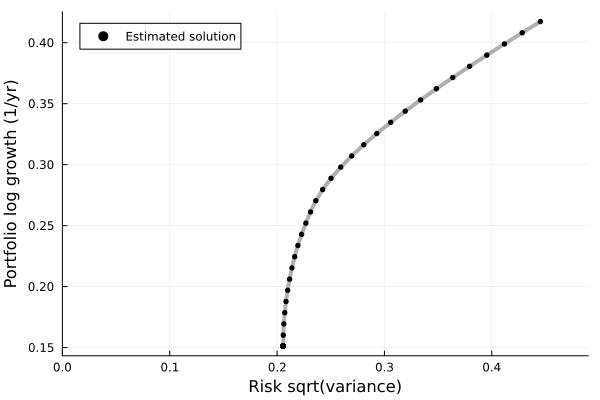

In [37]:
let
    plot(efficient_frontier, lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Portfolio log growth (1/yr)", fontsize=18, label="", c=:gray69, 
        xlim=(0.0, 1.1*maximum(efficient_frontier).first))
    scatter!(efficient_frontier, label="Estimated solution", c=:black, ms=3)
end

### What's in the min-var portfolio?
First, compute the minimum of the expected portfolio reward. Grab the `values` from the `efficient_frontier` dictionary using the [Julia values(...) function](https://docs.julialang.org/en/v1/base/collections/#Base.values); this call returns an iterator of the dictionary values. We then pass this iterator to the [Julia minimum function](https://docs.julialang.org/en/v1/base/collections/#Base.minimum) using the [Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). Save the minimum reward in the `min_var_reward` variable.

In [39]:
min_var_reward = values(efficient_frontier) |> minimum

0.1512287763325963

Next, let's recompute the solution and grab the weights for the `min_var_reward` portfolio by setting the `R` field on the `problem_risk` instance. We first initialize the `solution` variable to `nothing,` update the `problem_risk` instance and call the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}). We wrap the call to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) in [Julia's try-catch construct](https://docs.julialang.org/en/v1/base/base/#try) because the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) throws an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) if the problem is infeasible.

In [41]:
solution = nothing
try
    problem_risk.R = min_var_reward;
    solution = solve(problem_risk);
catch err
    println("Hmm. that didn't work like we expected ....");
end

Dict{String, Any} with 4 entries:
  "argmax"          => [0.157409, 0.425069, 0.108829, -3.53558e-9, -5.14677e-9,…
  "reward"          => 0.151284
  "status"          => LOCALLY_SOLVED
  "objective_value" => 0.0422852

`Unhide` the code block below to see how we build a table holding the portfolio weights for the `min_var_reward` portfolio:

In [43]:
let
    ω = solution["argmax"];
    table_df = DataFrame();
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        ωᵢ = ω[i];
        row_data = (
            ticker = ticker,
            ω = round(ωᵢ, digits=4) |> abs
        );
        push!(table_df,row_data)
    end
    
    # compute the total -
    total = table_df[:,:ω] |> sum
    last_row = (
        ticker = "total",
        ω = total
    )
    push!(table_df,last_row)
    table_df
end

Row,ticker,ω
,String,Float64
1,AAPL,0.1574
2,MSFT,0.4251
3,INTC,0.1088
4,MU,0.0
5,AMD,0.0
6,GS,0.1566
7,BAC,0.0
8,WFC,0.1488
9,C,0.0


### Task 3: Compute Optimal allocation with risky and risk-free assets
The Minimum-Variance (Markowitz) portfolio allocation problem for a portfolio composed of risk-free and risky assets $\mathcal{P}$ 
minimizes the variance of the portfolio $\sigma_{\mathcal{P}}^2$ 
subject to a minimal required return and non-negativity constraints: 

\begin{eqnarray*}
\text{minimize}~\sigma_{\mathcal{P}}^2 &=& \sum_{i\in\mathcal{P}}\sum_{j\in\mathcal{P}}\omega_{i}\omega_{j}
\text{cov}\left(r_{i},r_{j}\right) \\
\text{subject to}~\mathbb{E}(r_{\mathcal{P}})& = & \left(\omega_{f}r_{f}+\sum_{i\in\mathcal{P}}\omega_{i}\cdot\mathbb{E}(r_{i})\right)\geq{R^{*}}\\
\omega_{f}+\sum_{i\in\mathcal{P}}\omega_{i} & = & 1 \\
\text{and}~\omega_{i}&\geq&{0}\qquad{\forall{i}\in\mathcal{P}}
\end{eqnarray*}

The terms $\omega_{i}\geq{0}$ denote the fraction of risky asset $i\in\mathcal{P}$, 
the quantity $\omega_{f}$ denotes the fraction of risk-free assets in the portfolio, 
$r_{f}$ denotes the risk free rate or return, and $R^{*}$ is the minimum required rate of return 
for overall portfolio $\mathcal{P}$.

* Let's create an instance of the [MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem), and store this in the `problem_risk_free` variable, using the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem},%20NamedTuple}). We pass the covariance array estimated from data and the expected return value, along with bounds, an initial guess, and the risk-free rate to the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem},%20NamedTuple}):

In [45]:
problem_risk_free = build(MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem, (
    Σ = Σ̂,
    μ = μ̂,
    bounds = bounds,
    initial = wₒ,
    risk_free_rate = risk_free_rate,
    R = 0.0
));

Iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level in the presence of a risk-free asset using a `for-loop.` In particular, for each pass through the loop, we:
* Update the `problem_risk_free` variable with the minimum desired reward. We then pass the updated `problem_risk_free` object to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem}) (which initializes and solves the optimization problem). The solution returned from the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem}) is stored in the `solution_risk_free` dictionary. 
* We check the solution's `status.` If the status indicates an optimal solution was found, we store the solution in the `capital_allocation_line` dictionary.

In [47]:
capital_allocation_line = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_free.R = minimum_desired_reward_array[i];

    try
        # compute -
        solution_risk_free = solve(problem_risk_free)

        # check: did this converge?
        status_flag = solution_risk_free["status"];    
        if (status_flag == MathOptInterface.LOCALLY_SOLVED)
            key = sqrt(solution_risk_free["objective_value"]);
            value = solution_risk_free["reward"];
            capital_allocation_line[key] = value;
        end
    catch err
        println("Failed: desired R = $(problem_risk_free.R). Infeasible");
    end
end
capital_allocation_line;

### Visualize the capital allocation line
`Unhide` the code block below to see how we plotted the efficient frontier, i.e., the [minimum-variance solution](https://en.wikipedia.org/wiki/Modern_portfolio_theory) for the collection of equities and the [capital allocation line](https://en.wikipedia.org/wiki/Capital_allocation_line#:~:text=Capital%20allocation%20line%20(CAL)%20is,%2Dto%2Dvariability%20ratio%22.). In the presence of risk-free and risky assets, the optimal portfolio lies along the [capital allocation line](https://en.wikipedia.org/wiki/Capital_allocation_line#:~:text=Capital%20allocation%20line%20(CAL)%20is,%2Dto%2Dvariability%20ratio%22.).
* The [capital allocation line](https://en.wikipedia.org/wiki/Capital_allocation_line#:~:text=Capital%20allocation%20line%20(CAL)%20is,%2Dto%2Dvariability%20ratio%22.) intersects the `y-axis` at the risk-free rate. As we move up the [capital allocation line](https://en.wikipedia.org/wiki/Capital_allocation_line#:~:text=Capital%20allocation%20line%20(CAL)%20is,%2Dto%2Dvariability%20ratio%22.), it intersect the efficient frontier at the [tangent portfolio](https://en.wikipedia.org/wiki/Modern_portfolio_theory). In the tangent portfolio, all of your budget is invested in risky assets. On the other hand, at the risk-free rate all of your budget is invested in risk-free instruments, e.g., Treasury securities.

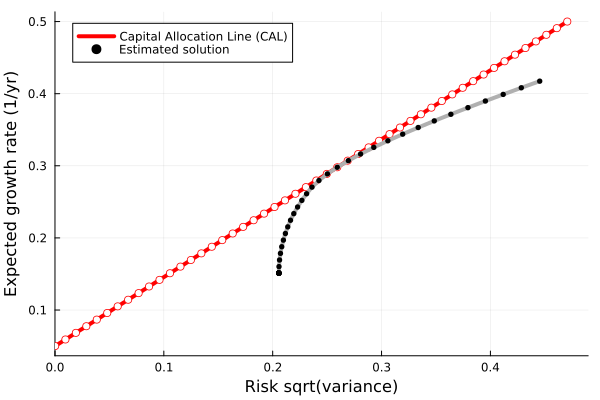

In [49]:
let
    plot(capital_allocation_line, lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Expected growth rate (1/yr)", fontsize=18, c=:red, 
        xlim=(0.0, 1.1*maximum(capital_allocation_line).first), label="Capital Allocation Line (CAL)")
    scatter!(capital_allocation_line, label="", msc=:red, mc=:white)
    plot!(efficient_frontier, lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Expected growth rate (1/yr)", fontsize=18, label="", c=:gray69, 
        xlim=(0.0, 1.1*maximum(efficient_frontier).first))
    scatter!(efficient_frontier, label="Estimated solution", c=:black, ms=3)
end

### Where is the tangent portfolio?
The tangent portfolio is the point on the capital allocation line where the fraction of assets invested in the pool of risky assets is 1, meaning all of our investment budget is invested in risky assets, such as equities. It's called the tangent portfolio because, at this point, the capital allocation line is tangent to the efficient frontier. Let's estimate the expected return of the tangent portfolio by trial and error.

In [51]:
problem_risk_free.R = 0.2978 # change this until fraction of risku assets = 1
allocation_sum_constraint = solve(problem_risk_free) |> x-> x["argmax"] |> x-> sum(x);
println("fraction in risk-free assets: $(1-allocation_sum_constraint), fraction in risky assets: $(allocation_sum_constraint)")

fraction in risk-free assets: -0.0008252406665705259, fraction in risky assets: 1.0008252406665705


Next, let's resolve the investment problem for the weights at the tangent portfolio:

In [53]:
tangent_portfolio_solution = nothing;
try 
    tangent_portfolio_solution = solve(problem_risk_free)
catch err
    println("Hmm. that didn't work like we expected ....");
end

Dict{String, Any} with 4 entries:
  "argmax"          => [0.247621, 0.470023, 1.93707e-8, 2.56469e-8, 0.283181, 4…
  "reward"          => 0.2978
  "status"          => LOCALLY_SOLVED
  "objective_value" => 0.0671579

`Unhide` the code block below to see how we build a table holding the portfolio weights for the `tangent_portfolio_solution` portfolio:

In [55]:
let
    ω = tangent_portfolio_solution["argmax"];
    table_df = DataFrame();
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        ωᵢ = ω[i];
        row_data = (
            ticker = ticker,
            ω = round(ωᵢ, digits=4)
        );
        push!(table_df,row_data)
    end
    
    # compute the total -
    total = table_df[:,:ω] |> sum
    last_row = (
        ticker = "total",
        ω = total
    )
    push!(table_df,last_row)
    table_df
end

Row,ticker,ω
,String,Float64
1,AAPL,0.2476
2,MSFT,0.47
3,INTC,0.0
4,MU,0.0
5,AMD,0.2832
6,GS,0.0
7,BAC,0.0
8,WFC,0.0
9,C,0.0


### Compute the fraction of risky assets as a function of the risk-aversion parameter $A$
How much of your investment budget should you put into risky assets, e.g., equities versus risk-free assets such as the U.S Treasury Securities? A __rational__ investor will maximize an investment's utility (satisfaction) subject to their _risk-aversion_. An example utility function describing the tradeoff between a risk-free asset and the tangent portfolio $\mathcal{T}$ is given by:
$$
\begin{equation*}
U(\theta) = r_{f} + \theta\cdot(\mathbb{E}\left(r_{\mathcal{T}}\right) - r_{f}) - \frac{A}{2}\cdot\theta^{2}\cdot\sigma_{\mathcal{T}}^{2}
\end{equation*}
$$
where $\theta$ is the fraction of the investor's wealth invested in the tangent portfolio $\mathcal{T}$, $r_{f}$ is the risk-free rate, 
$\sigma^{2}_{\mathcal{T}}$ is the variance of the return of the tangent portfolio, and $A>0$ is the investor's risk-aversion parameter.
Values of $\theta = 0$ represent a portfolio of only risk-free assets, while $\theta=1$ represents all assets invested in the tangent portfolio. Differentiating $U(\theta)$ with respect to $\theta$ and setting the result equal to zero yields the optimal $\theta^{\star}$:
$$
\begin{equation}
\theta^{\star} = \frac{\mathbb{E}\left(r_{\mathcal{T}}\right) - r_{f}}{A\cdot\sigma_{\mathcal{T}}^{2}}
\end{equation}
$$
As $A\rightarrow\infty$, the investor becomes more `risk-averse,` i.e., they are _less likely_ to tolerate uncertainty in the investment return. On the other hand, $A\rightarrow0$, the investor becomes more `risk-seeking,` i.e., they are _more comfortable_ with uncertainty in the investment return.

Set some values for the risk-aversion parameter $A\in\left(0,\infty\right)$ and look at what this does to our choices:

In [57]:
A = 10; # set a value for A (A big => risk averse)

# -- Below here, we compute the optimal θ̂ -------------------------------------- #
variance = tangent_portfolio_solution["objective_value"]
θ̂ = (problem_risk_free.R - risk_free_rate)/(A*variance);
risk_value = θ̂*sqrt(variance);
reward_value = θ̂*(problem_risk_free.R)+(1-θ̂)*problem_risk_free.risk_free_rate;
println("θ̂ = $(θ̂), reward = $(reward_value), risk (σ) = $(risk_value)")
# ------------------------------------------------------------------------------ #

θ̂ = 0.3689812148767355, reward = 0.14143354504645506, risk (σ) = 0.09562088947842676


## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.